<a href="https://colab.research.google.com/github/harishjungshahi/Deep-Learning/blob/main/Batch_normalization_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

#Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Normalize the Mnist Data

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
full_test_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)

train_subset = Subset(full_train_dataset, torch.arange(5000))
test_subset = Subset(full_test_dataset, torch.arange(1000))

train_loader = DataLoader(train_subset, batch_size=60, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=60, shuffle=True)

# Train a Neural Network without Batch Normalization

In [8]:
# Define the model
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [9]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs=5):

    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()          # Zero the gradients
            outputs = model(images)        # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                # Backpropagate
            optimizer.step()               # Update weights

            if batch%100 == 0:
                print(f"Epoch {epoch}, Batch: {batch}, Train Loss: {loss.item():0.2f}")


        # Evaluation
        model.eval()
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)

    return val_accuracies

In [10]:
# Instantiate the model, define loss function and optimizer
model = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

val_accuracies_no_bn = train_model(model, train_loader, test_loader, optimizer, criterion, 10)

Epoch 0, Batch: 0, Train Loss: 2.29
Epoch 1, Batch: 0, Train Loss: 0.77
Epoch 2, Batch: 0, Train Loss: 0.42
Epoch 3, Batch: 0, Train Loss: 0.39
Epoch 4, Batch: 0, Train Loss: 0.24
Epoch 5, Batch: 0, Train Loss: 0.27
Epoch 6, Batch: 0, Train Loss: 0.09
Epoch 7, Batch: 0, Train Loss: 0.20
Epoch 8, Batch: 0, Train Loss: 0.17
Epoch 9, Batch: 0, Train Loss: 0.07


In [11]:
print(val_accuracies_no_bn)

[0.837, 0.871, 0.89, 0.909, 0.918, 0.906, 0.926, 0.933, 0.942, 0.939]


### With Batch Normalization

In [13]:
# Define the model
class MNISTClassifierWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.network(x)

In [14]:
# Instantiate the model, define loss function and optimizer
model_with_bn = MNISTClassifierWithBN().to(device)
criterion_with_bn = nn.CrossEntropyLoss()
optimizer_with_bn = optim.Adam(model_with_bn.parameters(), lr=0.001)

val_accuracies_with_bn = train_model(model_with_bn, train_loader, test_loader, optimizer_with_bn, criterion_with_bn, 10)

Epoch 0, Batch: 0, Train Loss: 2.31
Epoch 1, Batch: 0, Train Loss: 0.30
Epoch 2, Batch: 0, Train Loss: 0.17
Epoch 3, Batch: 0, Train Loss: 0.15
Epoch 4, Batch: 0, Train Loss: 0.14
Epoch 5, Batch: 0, Train Loss: 0.05
Epoch 6, Batch: 0, Train Loss: 0.03
Epoch 7, Batch: 0, Train Loss: 0.02
Epoch 8, Batch: 0, Train Loss: 0.01
Epoch 9, Batch: 0, Train Loss: 0.01


In [15]:
val_accuracies_with_bn

[0.918, 0.958, 0.968, 0.988, 0.982, 0.993, 1.0, 0.999, 0.999, 0.994]

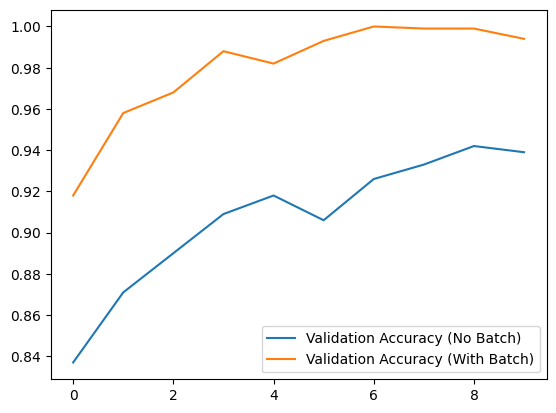

In [16]:
plt.plot(val_accuracies_no_bn, label="Validation Accuracy (No Batch)")
plt.plot(val_accuracies_with_bn, label="Validation Accuracy (With Batch)")
plt.legend()
plt.show()